# Modality translation

For modality translation task, you can use the unconditional model since its target is to generate out-of-distribution (ood) data. However, the Autoencoder needs a `size_factor` for the scRNA-seq decoder. Here, for unconditional model, we first run the leiden clustering algorithm to get the cluster id for each cell and use it to obtain the `size_factor`. For the ood data, we use the average of all clusters's size factor as its `size_factor`.

Again, you need to first train the Autoencoder and Diffusion backbone. Note that you should set the `norm_type` in the encoder config yaml to `layer_norm` since it's an ood generation task. The `script/training_diffusion/ssh_scripts/multimodal_train_translation.sh` is an example bash file for Diffusion backbone training for this task. The training logic is the same for this bash file and multimodal_train.sh except the dataset and other hyperparameters. 

Then, you can translate the modality from one to another:
```
cd script/training_diffusion
sh ssh_scripts/multimodal_translation.sh
```
You need to change the file path in both bash file to your local path. The `GEN_MODE` is the target modality (either "rna" or "atac" for current model).

After that, the generated cells latent representations will be saved in the `OUT_DIR`. You can follow the below script to decode them back to original space.

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '5'
import scanpy as sc
import anndata as ad
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from scipy import stats
from scdiffusionX.utils import MMD, LISI, random_forest, norm_total
import pandas as pd
from torch.distributions import Normal
from scvi.distributions import NegativeBinomial
from torch.distributions import Poisson, Bernoulli
import muon as mu
import yaml

from scdiffusionX.Autoencoder.data.scrnaseq_loader import RNAseqLoader
from scdiffusionX.Autoencoder.models.base.encoder_model import EncoderModel

/home/lep/miniconda3/envs/test/lib/python3.8/site-packages/lightning_lite/__init__.py:29: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('lightning_lite')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  __import__("pkg_resources").declare_namespace(__name__)
/home/lep/miniconda3/envs/test/lib/python3.8/site-packages/pytorch_lightning/__init__.py:45: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('pytorch_lightning')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  __import__("pkg_resources").declare_namespace(__name__)
/home/lep/miniconda3/envs/test/lib/python3.8/site-packages/umap/__init__.py:9: ImportWarning

You need to load the training dataset to obtain the size factor. Here we combine the training and test dataset into one h5mu file.

In [2]:
encoder_config = "script/training_autoencoder/configs/encoder/encoder_multimodal_large.yaml"
dataset_path = "/stor/lep/data/BABEL/all_w12878.h5mu" 
covariate_keys = "leiden"
num_class = 36  # since we use unconditional training, the num_class here represent the number of cluster
ae_path = "/stor/lep/workspace/multi_diffusion/CFGen/project_folder/experiments/train_autoencoder_babel_multimodal_layernorm_wd1e4/checkpoints/last.ckpt"

Load the test dataset:

In [3]:
mdata = mu.read_h5mu(dataset_path)
mdata_rna = mdata['rna']
real_cell = mdata_rna.X.toarray()[mdata_rna.obs['batch']=='test']  # this is the data for evaluation
mdata_atac = mdata['atac']
real_cell2 = mdata_atac.X.toarray()[mdata_atac.obs['batch']=='test']
real_cell.shape

(2004, 34861)

In [53]:
np.unique(mdata['rna'].obs['leiden'].values,return_counts=True)

(array(['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18',
        '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28',
        '29', '3', '30', '31', '32', '33', '34', '35', '4', '5', '6', '7',
        '8', '9'], dtype=object),
 array([2901, 2004, 1311, 1287, 1218, 1095,  993,  959,  893,  837,  816,
         787, 1914,  721,  578,  525,  465,  424,  424,  376,  373,  320,
         281, 1759,  275,  216,  209,  172,  118,  107, 1661, 1520, 1512,
        1460, 1379, 1378]))

Load the trained decoder and decode the latent representations back:

In [4]:
# get size factor for encoder. here we need all training data.
dataset = RNAseqLoader(data_path=dataset_path,
                            layer_key='X_counts',
                            covariate_keys=[covariate_keys],
                            subsample_frac=1, 
                            encoder_type='learnt_autoencoder',
                            multimodal=True,
                            is_binarized=True)

size_factor_statistics = {"mean": dataset.log_size_factor_mu, 
                            "sd": dataset.log_size_factor_sd}

def get_size_factor(type_index):
    covariate_indices = {}
    covariate_indices[covariate_keys] = type_index

    mean_size_factor, sd_size_factor = size_factor_statistics["mean"][covariate_keys], size_factor_statistics["sd"][covariate_keys]
    mean_size_factor, sd_size_factor = mean_size_factor[covariate_indices[covariate_keys]], sd_size_factor[covariate_indices[covariate_keys]]
    size_factor_dist = Normal(loc=mean_size_factor, scale=sd_size_factor)
    log_size_factor = size_factor_dist.sample().view(-1, 1)
    size_factor = torch.exp(log_size_factor)

    return {"rna": size_factor}

sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x71f26c092520>


In [5]:
# Load encoder and decoder
with open(encoder_config, 'r') as file:
    yaml_content = file.read()
autoencoder_args = yaml.safe_load(yaml_content)

# Initialize encoder
encoder_model = EncoderModel(in_dim={'atac': real_cell2.shape[1], 'rna': real_cell.shape[1]},
                                    n_cat=num_class,
                                    conditioning_covariate=covariate_keys, 
                                    encoder_type='learnt_autoencoder',
                                    **autoencoder_args)

# Load weights 
encoder_model.load_state_dict(torch.load(ae_path)["state_dict"])

<All keys matched successfully>

Read generated latent representation and decode back to gene expression/atac seq. Change the data path to your own:

In [ ]:
# only generate test set
rna_seq = np.load('../outputs/samples_trans/babel_nocondi_layernorm/80w_atac2rna_test_x5_grad3_640/RNA_0.npz')['data']
atac_seq = np.load('../outputs/samples_trans/babel_nocondi_layernorm/80w_rna2atac_test_x5_grad3_640/ATAC_0.npz')['data']
type_index = np.load('../outputs/samples_trans/babel_nocondi_layernorm/80w_rna2atac_test_x5_grad3_640/RNA_0.npz')['label']

# load norm factor for encoder
npzfile = np.load('/'.join(ae_path.split('/')[:-2])+'/norm_factor.npz')
rna_std = npzfile['rna_std']
atac_std = npzfile['atac_std']
z = {'rna':torch.tensor(rna_seq*rna_std).squeeze(1),'atac':torch.tensor(atac_seq*atac_std).squeeze(1)}     # open  layernorm

# get size factor and decode
size_factor = {}  # use the average of all factor in the training set as the factor of test set
mean = torch.ones(rna_seq.shape[0])*size_factor_statistics["mean"][covariate_keys][:-1].mean()  # average. [:-1] is to exclude the test set factor
std = torch.ones(rna_seq.shape[0])*size_factor_statistics["sd"][covariate_keys][:-1].mean()

size_factor_dist = Normal(loc=mean, scale=std)
log_size_factor_mean = size_factor_dist.sample().view(-1, 1)
size_factor_mean = torch.exp(log_size_factor_mean)

size_factor['rna'] = size_factor_mean  # note: if you include training set, you can use the real size factor for them instead of this average value

mu_hat = encoder_model.decode(z, size_factor)

sample = {}  # containing final samples 
for mod in mu_hat:
    if mod=="rna":  
        distr = NegativeBinomial(mu=mu_hat[mod], theta=torch.exp(encoder_model.theta))
    else:  # if mod is atac
        if not encoder_model.is_binarized:
            distr = Poisson(rate=mu_hat[mod])
        else:
            distr = Bernoulli(probs=mu_hat[mod])
    sample[mod] = distr.sample() 

reconstruct =  sample['rna'].detach().numpy()
reconstruct2 = sample['atac'].detach().numpy()

reconstruct.shape, reconstruct2.shape

((10020, 34861), (10020, 223897))

Here one modality is translated, and the other is decode directly from the given modality latent representation. Note that we translated the same given data more than once (5 times by default), we can filter those outlier cells to reduce noise:

In [7]:
# in only testset
val_gen_cells = reconstruct
real_size = (mdata_rna.obs['batch']=='test').sum()

dis = np.linalg.norm((val_gen_cells-val_gen_cells.mean(axis=0)),axis=1)
# find all the index where dis is smaller than the median value
filtered_indices = np.where(dis<np.median(dis))[0]
reconstruct = val_gen_cells[filtered_indices][:real_size]

reconstruct2 = reconstruct2[filtered_indices][:real_size]
reconstruct2.shape,reconstruct.shape

((2004, 223897), (2004, 34861))

In [14]:
# filter outlier cell to reduce noise 
# in both testset and validset (if you translate all train, valid and test set data)
'''
gen_split = []
reconstruct = []
reconstruct2 = []

for sp in ['val','test']:
    val_gen_cells = sample['rna'][mdata['rna'].obs['batch']==sp].detach().numpy()
    val_atac_cells = sample['atac'][mdata['atac'].obs['batch']==sp].detach().numpy()
    real_size = (mdata_rna.obs['batch']==sp).sum() 

    #cell filter
    dis = np.linalg.norm((val_gen_cells-val_gen_cells.mean(axis=0)),axis=1)
    # find all the index where dis is smaller than the median value
    filtered_indices = np.where(dis<np.median(dis))[0]

    filtered_cells = val_gen_cells[filtered_indices][:real_size]
    filtered_cells_atac = val_atac_cells[filtered_indices][:real_size]
    reconstruct.append(filtered_cells)
    reconstruct2.append(filtered_cells_atac)
    gen_split+=[sp]*filtered_cells.shape[0]

train_size = (mdata_rna.obs['batch']=='train').sum()
reconstruct.append(sample['rna'][mdata['rna'].obs['batch']=='train'].detach().numpy()[:train_size])
reconstruct2.append(sample['atac'][mdata['atac'].obs['batch']=='train'].detach().numpy()[:train_size])
gen_split+=['train']*sample['rna'][mdata['rna'].obs['batch']=='train'].detach().numpy()[:train_size].shape[0]
reconstruct = np.concatenate(reconstruct,axis=0)
reconstruct2 = np.concatenate(reconstruct2,axis=0)
reconstruct.shape,reconstruct2.shape
'''

"\ngen_split = []\nreconstruct = []\nreconstruct2 = []\n\nfor sp in ['val','test']:\n    val_gen_cells = sample['rna'][mdata['rna'].obs['batch']==sp].detach().numpy()\n    val_atac_cells = sample['atac'][mdata['atac'].obs['batch']==sp].detach().numpy()\n    real_size = (mdata_rna.obs['batch']==sp).sum() \n\n    #cell filter\n    dis = np.linalg.norm((val_gen_cells-val_gen_cells.mean(axis=0)),axis=1)\n    # find all the index where dis is smaller than the median value\n    filtered_indices = np.where(dis<np.median(dis))[0]\n\n    filtered_cells = val_gen_cells[filtered_indices][:real_size]\n    filtered_cells_atac = val_atac_cells[filtered_indices][:real_size]\n    reconstruct.append(filtered_cells)\n    reconstruct2.append(filtered_cells_atac)\n    gen_split+=[sp]*filtered_cells.shape[0]\n\ntrain_size = (mdata_rna.obs['batch']=='train').sum()\nreconstruct.append(sample['rna'][mdata['rna'].obs['batch']=='train'].detach().numpy()[:train_size])\nreconstruct2.append(sample['atac'][mdata['a

In [8]:
real_cell = norm_total(real_cell)
reconstruct = norm_total(reconstruct)

Finally, you get the translated modality. You can evaluate them using the following script. Here we provide evaluation code for both modalities, you can choose the one you've translated.

In [9]:
# For scRNA-seq
print('RNA')
print(real_cell.mean())
print(reconstruct.mean())
print('spearman bulk=',stats.spearmanr(real_cell.mean(axis=0), reconstruct.mean(axis=0)).correlation)
print('pearson bulk=',np.corrcoef(real_cell.mean(axis=0), reconstruct.mean(axis=0))[0][1])

# For scATAC-seq
print('\nATAC')
print(real_cell2.mean())
print(reconstruct2.mean())
print('spearman mean=',stats.spearmanr(real_cell2.mean(axis=0), reconstruct2.mean(axis=0)).correlation)
print('pearson mean=',np.corrcoef(real_cell2.mean(axis=0), reconstruct2.mean(axis=0))[0][1])

RNA
0.28685427
0.28685394
spearman bulk= 0.9587163780543091
pearson bulk= 0.9890751070159878

ATAC
0.0183027
0.015778793
spearman mean= 0.9328526040814712
pearson mean= 0.9629978144727642


In [10]:
# For scRNA-seq
print('RNA')
adata = np.concatenate((real_cell, reconstruct),axis=0)
adata = ad.AnnData(adata, dtype=np.float32)
adata.obs_names = [f"true_Cell" for i in range(real_cell.shape[0])]+[f"gen_Cell" for i in range(reconstruct.shape[0])]
sc.tl.pca(adata, svd_solver='arpack')
adata.obs['batch'] = pd.Categorical([f"true_Cell" for i in range(real_cell.shape[0])]+[f"gen_Cell" for i in range(reconstruct.shape[0])])
print('MMD = ', MMD(adata))
print('LISI = ', LISI(adata))

# For scATAC-seq
print('\nATAC')
adata = np.concatenate((real_cell2, reconstruct2),axis=0)
adata = ad.AnnData(adata, dtype=np.float32)
adata.obs_names = [f"true_Cell" for i in range(real_cell2.shape[0])]+[f"gen_Cell" for i in range(reconstruct2.shape[0])]
sc.tl.pca(adata, svd_solver='arpack')
adata.obs['batch'] = pd.Categorical([f"true_Cell" for i in range(real_cell2.shape[0])]+[f"gen_Cell" for i in range(reconstruct2.shape[0])])
print('MMD = ', MMD(adata))
print('LISI = ', LISI(adata))

RNA


100%|██████████| 21/21 [00:01<00:00, 11.95it/s]


MMD =  tensor(0.2673)
LISI =  0.5451907826825102

ATAC


100%|██████████| 21/21 [00:01<00:00, 15.15it/s]


MMD =  tensor(0.2004)
LISI =  0.6503895890208606


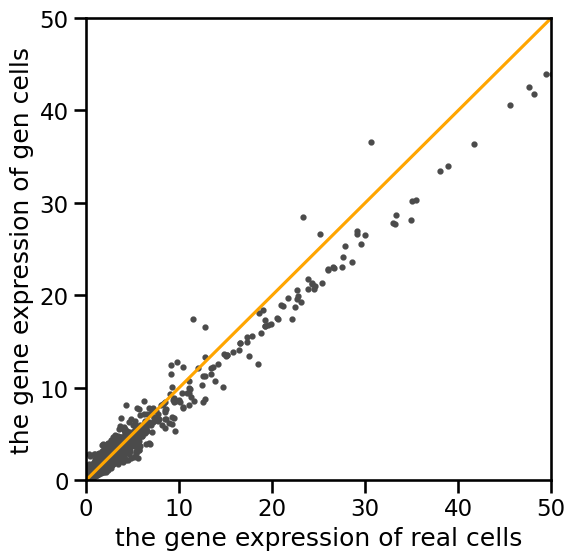

In [11]:
# scatter plot for scRNA-seq
plt.figure(figsize=(6,6))
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
lim = 50
plt.ylim((-0,lim))
plt.xlim((-0,lim))
plt.ylabel('the gene expression of gen cells')
plt.xlabel('the gene expression of real cells')
plt.scatter(real_cell.mean(axis=0),reconstruct.mean(axis=0),s=9,color='#4B4B4B')
plt.plot([0,lim],[0,lim],color='orange')

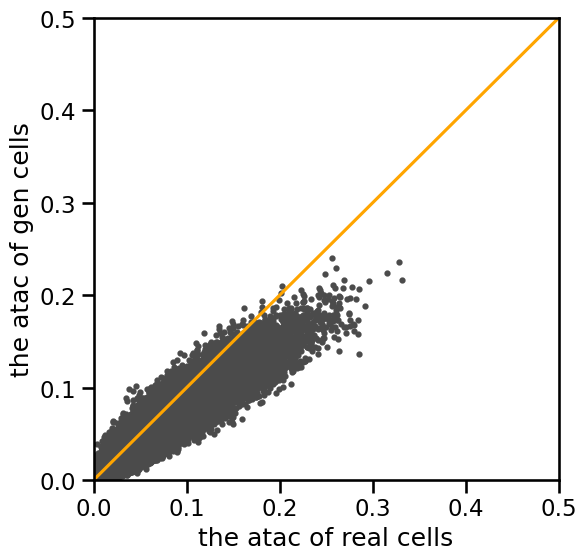

In [12]:
# scatter plot for scATAC-seq
plt.figure(figsize=(6,6))
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
lim = 0.5
plt.ylim((-0,lim))
plt.xlim((-0,lim))
plt.ylabel('the atac of gen cells')
plt.xlabel('the atac of real cells')
plt.scatter(real_cell2.mean(axis=0),reconstruct2.mean(axis=0),s=9,color='#4B4B4B')
plt.plot([0,lim],[0,lim],color='orange')

Gene perturbation is anthoer thing you can do once you done training the model. You can perturb the specific genes by set theirs expression value to zero (or a very high value) and then translate the scRNA-seq to scATAC-seq to see the effect of perturbations:
```
cd script/training_diffusion
sh ssh_scripts/multimodal_perturb.sh
```
You need to change the file path in both bash file to your local path. The `GEN_MODE` is the target modality (either "rna" or "atac" for current model). The `target_gene` is the perturbed genes. In this task, you can use meta information to obtain the `size_factor` instead of leidem clustering. However, since it is still an ood generation task, we use unconditional generation mode. The `target_type` is the cell types of the target cells. The `pert` is to decide weather generate control group, True is perturb group and False is control group.

We can then evaluate the predicted perturbation scATAC-seq with the ground truth data.

In [2]:
# load ground truth
# this data can be downloaded from http://www.perturbase.cn/static/PRJNA658075/PRJNA658075.filter.tar.gz
pert = sc.read_h5ad('/stor/lep/workspace/multi_diffusion/filtered.h5ad')

/home/lep/miniconda3/envs/test/lib/python3.8/site-packages/anndata/_io/utils.py:202: OldFormatWarning: Element '/obs/__categories/gene' was written without encoding metadata.
  return func(*args, **kwargs)
/home/lep/miniconda3/envs/test/lib/python3.8/site-packages/anndata/_io/utils.py:202: OldFormatWarning: Element '/obs/gene' was written without encoding metadata.
  return func(*args, **kwargs)
/home/lep/miniconda3/envs/test/lib/python3.8/site-packages/anndata/_io/utils.py:202: OldFormatWarning: Element '/obs/_index' was written without encoding metadata.
  return func(*args, **kwargs)
/home/lep/miniconda3/envs/test/lib/python3.8/site-packages/anndata/_io/utils.py:202: OldFormatWarning: Element '/var/_index' was written without encoding metadata.
  return func(*args, **kwargs)


In [3]:
# training data
dataset_path = '/stor/lep/diffusion/multiome/openproblem_filtered4perturb.h5mu'
mdata = mu.read_h5mu(dataset_path)
mdata['atac'].var_names = [name.replace(':','-') for name in mdata['atac'].var_names]

/home/lep/miniconda3/envs/test/lib/python3.8/site-packages/anndata/_core/anndata.py:453: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(
/home/lep/miniconda3/envs/test/lib/python3.8/site-packages/anndata/_core/anndata.py:453: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(


You need to align the chromosome regions of the training data and the ground truth data first. Here we select the overlaped regions in the train and ground truth data.

In [4]:
def parse_region(region):
    """Parses chromosome region strings into tuples of (chromosome, start position, end position)"""
    chr_id, start, end = region.split('-')
    return chr_id, int(start), int(end)

def calculate_overlap(region1, region2):
    """Calculate the overlap length of two chromosome regions"""
    chr1, start1, end1 = region1
    chr2, start2, end2 = region2
    if chr1 == chr2:  # 只有染色体相同才计算重叠
        overlap = max(0, min(end1, end2) - max(start1, start2))
        return overlap
    return 0

In [5]:
# Align chromosome regions
results_all = []

for region1 in mdata['atac'].var_names:
    chr1, start1, end1 = parse_region(region1)
    max_overlap = 0
    best_match = None
    for region2 in pert.var_names.values:
        chr2, start2, end2 = parse_region(region2)
        if chr2 != chr1:
            continue
        overlap = calculate_overlap((chr1, start1, end1), (chr2, start2, end2))
        if overlap > max_overlap:
            max_overlap = overlap
            best_match = region2
    if best_match is not None:
        results_all.append(best_match)

Preprocess the ground truth data, find the high variable region.

In [6]:
# find the overlap chromosome regions between training data and ground truth data
filtered_genes = pert.var.index.isin(np.unique(results_all))
pert = pert[:,filtered_genes]
sc.pp.normalize_total(pert, 1e4)
sc.pp.log1p(pert)
pert

/home/lep/miniconda3/envs/test/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


AnnData object with n_obs × n_vars = 5816 × 5962
    obs: 'gene'
    uns: 'log1p'

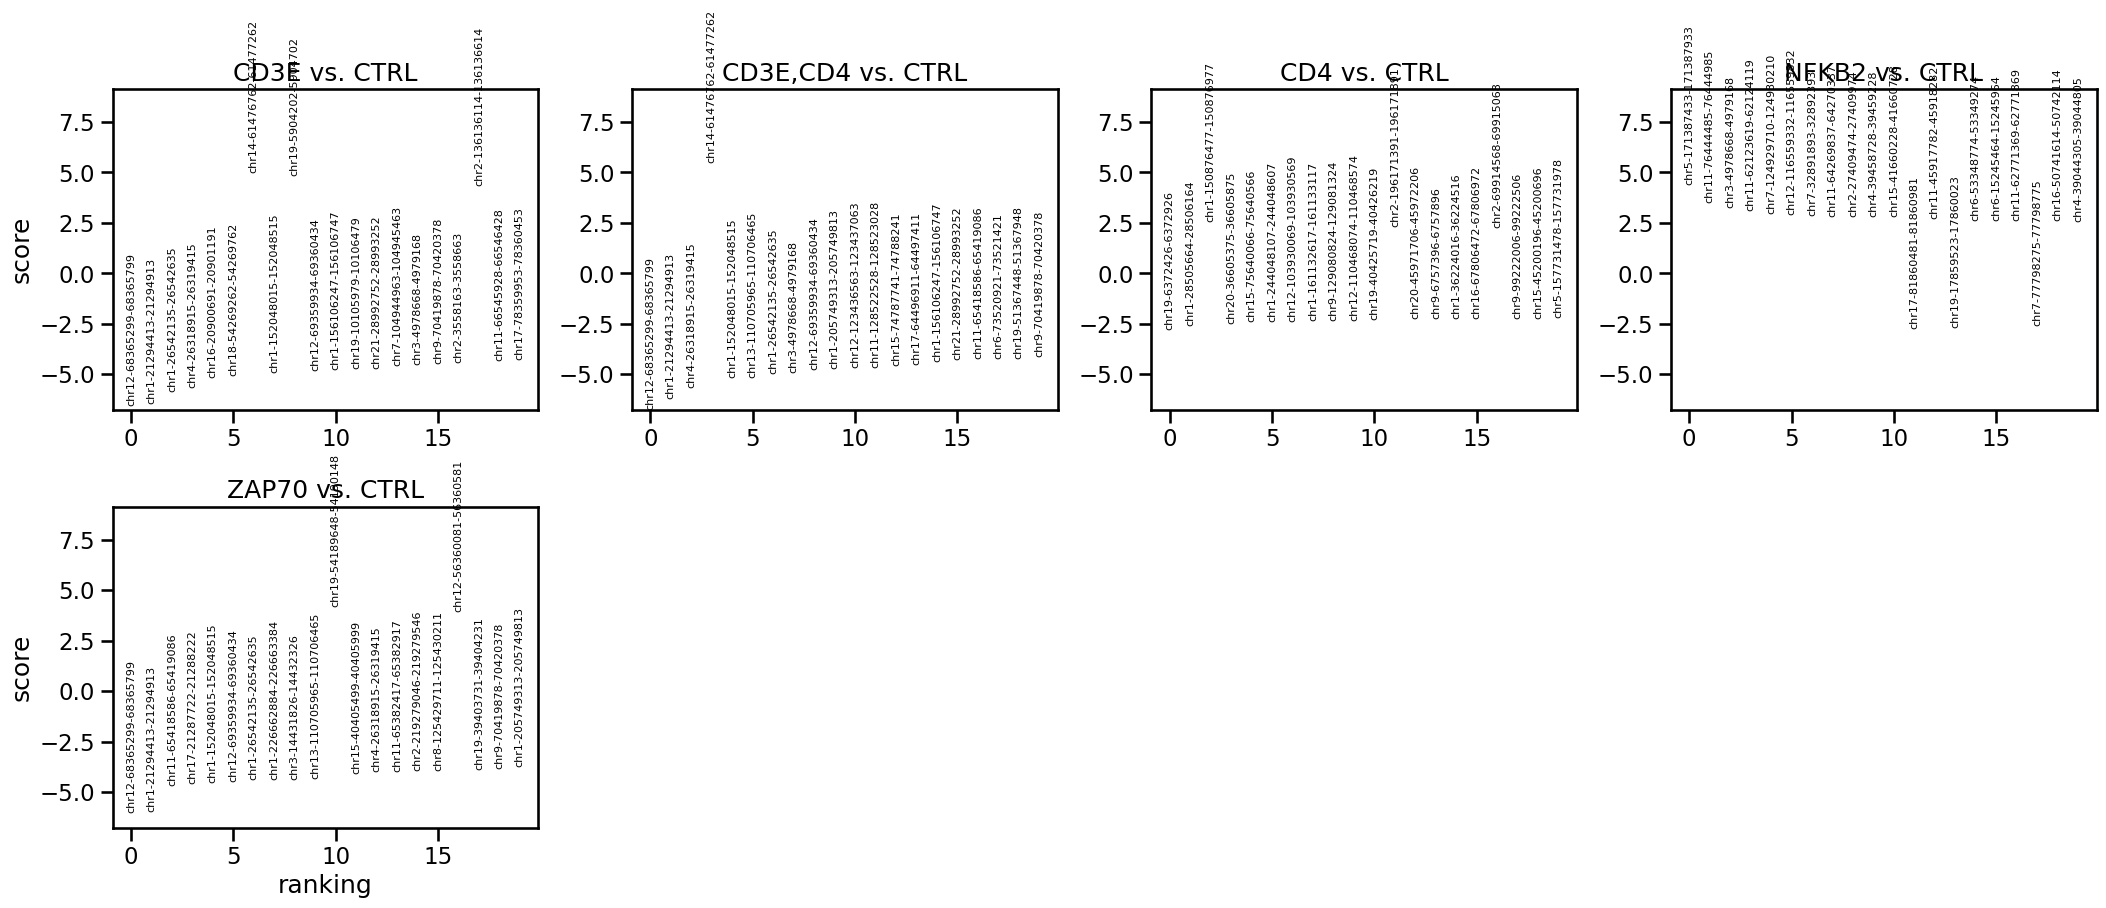

In [7]:
# calculate differential region
sc.tl.rank_genes_groups(pert,'gene', method='wilcoxon',reference='CTRL',rankby_abs=True) 
sc.pl.rank_genes_groups(pert)

Choose the perturb gene and calculate the change direction of differential peak

In [8]:
rec_arr = pert.uns['rank_genes_groups']['names']
target_gene = 'CD3E,CD4'  #'CD3E' 'NFKB2' 'ZAP70' 'CD3E,CD4'
de_gene = np.array([rec_arr[target_gene],])[0,:300]
atac_pert = (pert[pert.obs['gene']==target_gene,de_gene].X.toarray()).astype(np.float32)
atac_ctrl = (pert[pert.obs['gene']=='CTRL',de_gene].X.toarray()).astype(np.float32)
direction_real = atac_pert.mean(0) - atac_ctrl.mean(0)
direction_real.shape

(300,)

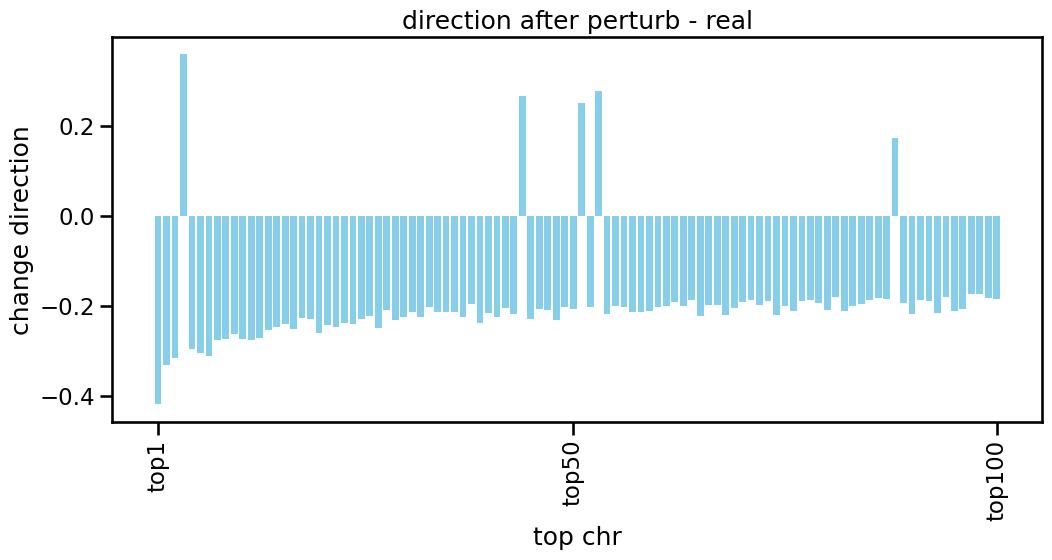

In [9]:
x_tick = [chr[:12] for chr in de_gene[:100]]
plt.figure(figsize=(12,5))
plt.bar(x_tick, direction_real[:100], color='skyblue')
plt.xticks([0,49,99],['top1','top50','top100'],rotation=90)
plt.title('direction after perturb - real')
plt.xlabel('top chr')
plt.ylabel('change direction')
plt.show()

Load AE and decode your predicted scATAC-seq. Here, since the dataset is filtered, we use the small AE (encoder_multimodal_small).

In [10]:
encoder_config = "encoder_multimodal_small"
dataset_path = "/stor/lep/diffusion/multiome/openproblem_filtered4perturb.h5mu" 
covariate_keys = "cell_type"
num_class = 22
ae_path = "/stor/lep/workspace/multi_diffusion/CFGen/project_folder/experiments/train_autoencoder_openproblem_multimodal_perturb/checkpoints/last.ckpt"

In [11]:
mdata = mu.read_h5mu(dataset_path)
real_cell = mdata['rna'].X.toarray()
real_cell2 = mdata['atac'].X.toarray()
real_cell.shape

/home/lep/miniconda3/envs/test/lib/python3.8/site-packages/anndata/_core/anndata.py:453: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(
/home/lep/miniconda3/envs/test/lib/python3.8/site-packages/anndata/_core/anndata.py:453: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(


(69249, 2503)

In [12]:
dataset = RNAseqLoader(data_path=dataset_path,
                            layer_key='X_counts',
                            covariate_keys=[covariate_keys],
                            subsample_frac=1, 
                            encoder_type='learnt_autoencoder',
                            multimodal=True,
                            is_binarized=True)

size_factor_statistics = {"mean": dataset.log_size_factor_mu, 
                            "sd": dataset.log_size_factor_sd}

def get_size_factor(type_index):
    covariate_indices = {}
    covariate_indices[covariate_keys] = type_index

    mean_size_factor, sd_size_factor = size_factor_statistics["mean"][covariate_keys], size_factor_statistics["sd"][covariate_keys]
    mean_size_factor, sd_size_factor = mean_size_factor[covariate_indices[covariate_keys]], sd_size_factor[covariate_indices[covariate_keys]]
    size_factor_dist = Normal(loc=mean_size_factor, scale=sd_size_factor)
    log_size_factor = size_factor_dist.sample().view(-1, 1)
    size_factor = torch.exp(log_size_factor)

    return {"rna": size_factor}

/home/lep/miniconda3/envs/test/lib/python3.8/site-packages/anndata/_core/anndata.py:453: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(
/home/lep/miniconda3/envs/test/lib/python3.8/site-packages/anndata/_core/anndata.py:453: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(


In [14]:
with open(f'{os.getcwd()}/../script/training_autoencoder/configs/encoder/{encoder_config}.yaml', 'r') as file:
    yaml_content = file.read()
autoencoder_args = yaml.safe_load(yaml_content)

# Initialize encoder
autoencoder_args['encoder_kwargs']['rna']['norm_type']='layernorm'
autoencoder_args['encoder_kwargs']['atac']['norm_type']='layernorm'
encoder_model = EncoderModel(in_dim={'atac': real_cell2.shape[1], 'rna': real_cell.shape[1]},
                                    n_cat=num_class,
                                    conditioning_covariate=covariate_keys, 
                                    encoder_type='learnt_autoencoder',
                                    **autoencoder_args)

# Load weights 
encoder_model.load_state_dict(torch.load(ae_path)["state_dict"])

/tmp/ipykernel_1581346/2445380897.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder_model.load_state_dict(torch.load(ae_path)["state_dict"])


<All keys matched successfully>

Again, change the path to your local path. Decode the perturb group:

In [18]:
# load predicted perturb atac-seq
# rna_seq = np.load(f'../outputs/samples_trans/open_uncondi_layernorm_pert/80w_atac2rna_CTRL_{target_gene}_top5_x5/RNA_0.npz')['data']
# atac_seq = np.load(f'../outputs/samples_trans/open_uncondi_layernorm_pert/80w_rna2atac_{target_gene}_top5_x5/ATAC_0.npz')['data']
# type_index = np.load(f'../outputs/samples_trans/open_uncondi_layernorm_pert/80w_atac2rna_CTRL_{target_gene}_top5_x5/RNA_0.npz')['label']
rna_seq = np.load(f'/stor/lep/workspace/multi_diffusion/MM-Diffusion/outputs/samples_trans/open_uncondi_layernorm_pert/80w_atac2rna_CTRL_{target_gene}_top5_x5/RNA_0.npz')['data']
atac_seq = np.load(f'/stor/lep/workspace/multi_diffusion/MM-Diffusion/outputs/samples_trans/open_uncondi_layernorm_pert/80w_rna2atac_{target_gene}_top5_x5/ATAC_0.npz')['data']
type_index = np.load(f'/stor/lep/workspace/multi_diffusion/MM-Diffusion/outputs/samples_trans/open_uncondi_layernorm_pert/80w_atac2rna_CTRL_{target_gene}_top5_x5/RNA_0.npz')['label']

times = 5
rna_seq = rna_seq.reshape(times,-1,rna_seq.shape[-1])[0]#.mean(0)
# atac_seq = atac_seq.reshape(times,-1,atac_seq.shape[-1])[0]#.mean(0)
type_index = type_index[:rna_seq.shape[0]]

npzfile = np.load('/'.join(ae_path.split('/')[:-2])+'/norm_factor.npz')
rna_std = npzfile['rna_std']
atac_std = npzfile['atac_std']
z = {'rna':torch.tensor(rna_seq*rna_std).squeeze(1),'atac':torch.tensor(atac_seq*atac_std).squeeze(1)}     # open  layernorm

size_factor = get_size_factor(torch.tensor(type_index,dtype=torch.int))  # use ground truth factor
mu_hat = encoder_model.decode(z, size_factor)

# mu_hat['rna'] = mu_hat['rna'].reshape(times,-1,mu_hat['rna'].shape[-1]).mean(0)
mu_hat['atac'] = mu_hat['atac'].reshape(times,-1,mu_hat['atac'].shape[-1]).mean(0)

sample = {}  # containing final samples 
for mod in mu_hat:
    if mod=="rna":  
        # if not self.covariate_specific_theta:
        distr = NegativeBinomial(mu=mu_hat[mod], theta=torch.exp(encoder_model.theta))
    else:  # if mod is atac
        distr = Bernoulli(probs=mu_hat[mod])
    sample[mod] = distr.sample() 

reconstruct_pert = mu_hat['rna'].detach().numpy()
reconstruct2_pert = mu_hat['atac'].detach().numpy()

reconstruct_pert.shape, reconstruct2_pert.shape

((564, 2503), (564, 6016))

Decode the control group:

In [20]:
# also load predicted control atac-seq
rna_seq = np.load(f'/stor/lep/workspace/multi_diffusion/MM-Diffusion/outputs/samples_trans/open_uncondi_layernorm_pert/80w_atac2rna_CTRL_{target_gene}_top5_x5/RNA_0.npz')['data']#[:3064]
atac_seq = np.load(f'/stor/lep/workspace/multi_diffusion/MM-Diffusion/outputs/samples_trans/open_uncondi_layernorm_pert/80w_rna2atac_CTRL_{target_gene}_top5_x5/ATAC_0.npz')['data']#[:3064]
type_index = np.load(f'/stor/lep/workspace/multi_diffusion/MM-Diffusion/outputs/samples_trans/open_uncondi_layernorm_pert/80w_atac2rna_CTRL_{target_gene}_top5_x5/RNA_0.npz')['label']

times = 5
rna_seq = rna_seq.reshape(times,-1,rna_seq.shape[-1])[0]#.mean(0)
# atac_seq = atac_seq.reshape(times,-1,atac_seq.shape[-1])[0]#.mean(0)
type_index = type_index[:rna_seq.shape[0]]

npzfile = np.load('/'.join(ae_path.split('/')[:-2])+'/norm_factor.npz')
rna_std = npzfile['rna_std']
atac_std = npzfile['atac_std']
z = {'rna':torch.tensor(rna_seq*rna_std).squeeze(1),'atac':torch.tensor(atac_seq*atac_std).squeeze(1)}     # open  layernorm

size_factor = get_size_factor(torch.tensor(type_index,dtype=torch.int))  # cell type average

mu_hat = encoder_model.decode(z, size_factor)

# mu_hat['rna'] = mu_hat['rna'].reshape(times,-1,mu_hat['rna'].shape[-1]).mean(0)
mu_hat['atac'] = mu_hat['atac'].reshape(times,-1,mu_hat['atac'].shape[-1]).mean(0)

sample = {}  # containing final samples 
for mod in mu_hat:
    if mod=="rna":  
        # if not self.covariate_specific_theta:
        distr = NegativeBinomial(mu=mu_hat[mod], theta=torch.exp(encoder_model.theta))
    else:  # if mod is atac
        distr = Bernoulli(probs=mu_hat[mod])
    sample[mod] = distr.sample() 

reconstruct_ctrl = mu_hat['rna'].detach().numpy()
reconstruct2_ctrl = mu_hat['atac'].detach().numpy()

reconstruct_ctrl.shape, reconstruct2_ctrl.shape

((564, 2503), (564, 6016))

In [24]:
# normalize
reconstruct2_pert=norm_total(reconstruct2_pert, 1e4)
reconstruct2_ctrl=norm_total(reconstruct2_ctrl, 1e4)

To evaluate the predict perturbation, we need to find the corresponding region align with the differential region in the ground truth data:

In [25]:
results = []

for region1 in de_gene:
    chr1, start1, end1 = parse_region(region1)
    max_overlap = 0
    best_match = None
    for region2 in mdata['atac'].var_names:
        chr2, start2, end2 = parse_region(region2)
        if chr2 != chr1:
            continue
        overlap = calculate_overlap((chr1, start1, end1), (chr2, start2, end2))
        if overlap > max_overlap:
            max_overlap = overlap
            best_match = region2
    results.append((region1, best_match, max_overlap))

Calculate change directions of these differential regions and the accuracy to the ground truth directions:

In [26]:
pred_pert = reconstruct2_pert
pred_ctrl = reconstruct2_ctrl
direction_pred_pred = pred_pert.mean(0) - pred_ctrl.mean(0)
direction = []
for item in results:
    if item[1] is not None:
        direction.append(direction_pred_pred[np.where(mdata['atac'].var_names == item[1])[0][0]])
    else:
        direction.append(0)

In [27]:
from sklearn.metrics import accuracy_score

direction_random = np.random.randint(0, 2, size=300)

total_acc = []
posi_acc = []
nega_acc = []
total_acc_random = []
posi_acc_random = []
nega_acc_random = []
for num in [20,50,100,200,300]:
    accuracy = accuracy_score(np.array(direction_real[:num])>0, np.array(direction[:num])>0)
    total_acc.append(accuracy)
    print(f'top {num} total acc: ', accuracy)
    index_posi = np.where(np.array(direction_real[:num])>0)[0]
    accuracy = accuracy_score(np.array(direction_real[:num])[index_posi]>0, np.array(direction[:num])[index_posi]>0)
    posi_acc.append(accuracy)
    print('positive acc: ', accuracy)
    index_posi = np.where(np.array(direction_real[:num])<0)[0]
    accuracy = accuracy_score(np.array(direction_real[:num])[index_posi]>0, np.array(direction[:num])[index_posi]>0)
    nega_acc.append(accuracy)
    print('negative acc: ', accuracy)    

    # accuracy = accuracy_score(np.array(direction_real[:num])>0, np.array(direction_random[:num])>0)
    # total_acc_random.append(accuracy)
    # print(f'top {num} total acc random: ', accuracy)
    # index_posi = np.where(np.array(direction_real[:num])>0)[0]
    # accuracy = accuracy_score(np.array(direction_real[:num])[index_posi]>0, np.array(direction_random[:num])[index_posi]>0)
    # posi_acc_random.append(accuracy)
    # print('positive acc random: ', accuracy)
    # index_posi = np.where(np.array(direction_real[:num])<0)[0]
    # accuracy = accuracy_score(np.array(direction_real[:num])[index_posi]>0, np.array(direction_random[:num])[index_posi]>0)
    # nega_acc_random.append(accuracy)
    # print('negative acc random: ', accuracy)   

top 20 total acc:  0.8
positive acc:  1.0
negative acc:  0.7894736842105263
top 50 total acc:  0.82
positive acc:  1.0
negative acc:  0.8125
top 100 total acc:  0.77
positive acc:  1.0
negative acc:  0.7578947368421053
top 200 total acc:  0.73
positive acc:  0.8181818181818182
negative acc:  0.7248677248677249
top 300 total acc:  0.6833333333333333
positive acc:  0.7647058823529411
negative acc:  0.6784452296819788


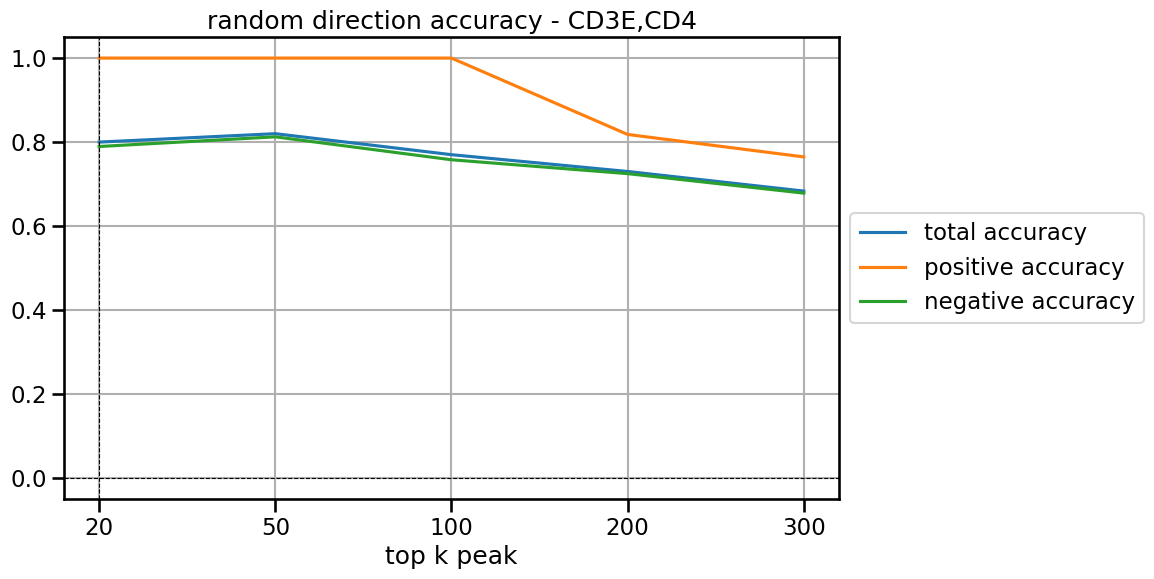

In [43]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.figure(figsize=(10, 6))  # 设置图形大小
x = np.linspace(0, 4, 5)
plt.plot(x, total_acc, label='total accuracy') 
plt.plot(x, posi_acc, label='positive accuracy') 
plt.plot(x, nega_acc, label='negative accuracy') 


# 设置图形属性
plt.title(f'random direction accuracy - {target_gene}')        # 设置标题
plt.xlabel('top k peak')                    # 设置 x 轴标签
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(x, ['20','50','100','200','300'])
# plt.yticks([])
# plt.ylabel('Y-axis')                    # 设置 y 轴标签
# plt.ylim(0.2, 0.65)                       # 设置 y 轴范围
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')  # 添加水平参考线
plt.axvline(0, color='black', linewidth=0.8, linestyle='--')  # 添加垂直参考线
plt.grid()                              # 添加网格
# plt.legend()                            # 显示图例
